In [3]:
!pip install --quiet datasketch langdetect tqdm nltk

import os, re, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from tqdm.notebook import tqdm
from langdetect import detect
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from datasketch import MinHash, MinHashLSH
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

random.seed(42)
np.random.seed(42)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 4.1 MB/s eta 0:00:00


In [4]:
os.environ['KAGGLE_USERNAME'] = "togzhanseitzh"
os.environ['KAGGLE_KEY'] = "4eec528a3d9decf4211fd8a7b4adb435"

!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip -n amazon-books-reviews.zip


Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.05G/1.06G [00:05<00:00, 210MB/s]
100% 1.06G/1.06G [00:05<00:00, 202MB/s]
Archive:  amazon-books-reviews.zip
  inflating: Books_rating.csv        
  inflating: books_data.csv          


In [5]:
CSV_PATH = "Books_rating.csv"
NROWS_SAMPLE = 8000

print(f"Loading {NROWS_SAMPLE} rows from dataset...")
df = pd.read_csv(CSV_PATH, nrows=NROWS_SAMPLE, usecols=['review/text', 'review/summary'])
df['review/text'] = df['review/text'].fillna('')
df['review/summary'] = df['review/summary'].fillna('')
df['full_text'] = (df['review/summary'] + ' ' + df['review/text']).str.strip()
df = df[df['full_text'] != ''].reset_index(drop=True)
print("Rows after cleaning:", len(df))

Loading 8000 rows from dataset...
Rows after cleaning: 8000


In [6]:
USE_PROGRESS = True

if USE_PROGRESS:
    tqdm.pandas()

def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

print("Filtering non-English reviews...")
if USE_PROGRESS:
    df = df[df['full_text'].progress_apply(is_english)].reset_index(drop=True)
else:
    df = df[df['full_text'].apply(is_english)].reset_index(drop=True)

print("Remaining after English filter:", len(df))


Filtering non-English reviews...


  0%|          | 0/8000 [00:00<?, ?it/s]

Remaining after English filter: 7956


In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = [lemmatizer.lemmatize(t) for t in text.split()
              if t not in stop_words and len(t) > 2]
    return set(tokens)

print("Preprocessing text...")
if USE_PROGRESS:
    df['tokens'] = df['full_text'].progress_apply(preprocess)
else:
    df['tokens'] = df['full_text'].apply(preprocess)

df = df[df['tokens'].map(bool)].reset_index(drop=True)
print("Rows after dropping empties:", len(df))


Preprocessing text...


  0%|          | 0/7956 [00:00<?, ?it/s]

Rows after dropping empties: 7956


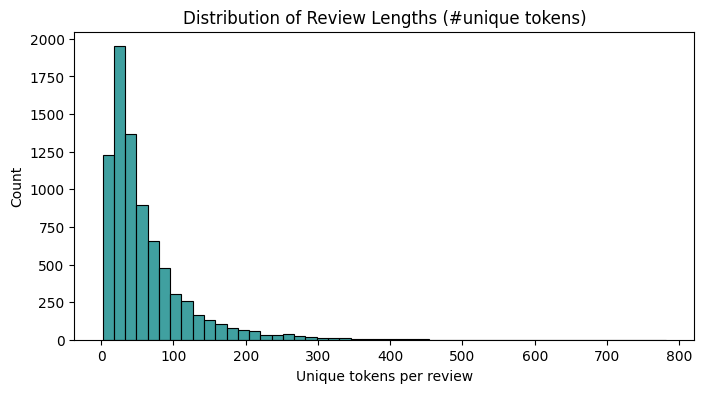

In [8]:
df['length'] = df['tokens'].map(len)

plt.figure(figsize=(8,4))
sns.histplot(df['length'], bins=50, color="teal")
plt.title("Distribution of Review Lengths (#unique tokens)")
plt.xlabel("Unique tokens per review")
plt.ylabel("Count")
plt.show()


In [9]:
NUM_PERM = 128
LSH_THRESHOLD = 0.8
print("Building MinHash signatures...")

minhashes = []
for tokens in tqdm(df['tokens']):
    m = MinHash(num_perm=NUM_PERM)
    for token in tokens:
        m.update(token.encode('utf8'))
    minhashes.append(m)

lsh = MinHashLSH(threshold=LSH_THRESHOLD, num_perm=NUM_PERM)
for i, mh in enumerate(minhashes):
    lsh.insert(str(i), mh)

print("Querying LSH...")
similar_pairs = []
for i, mh in enumerate(minhashes):
    for cand in lsh.query(mh):
        j = int(cand)
        if i < j:
            A, B = df.loc[i,'tokens'], df.loc[j,'tokens']
            jac = len(A & B) / len(A | B) if A and B else 0
            if jac >= LSH_THRESHOLD:
                similar_pairs.append((i, j, jac))

print(f"LSH found {len(similar_pairs)} pairs with Jaccard ≥ {LSH_THRESHOLD}")

# Show 3 examples
for i,j,score in sorted(similar_pairs, key=lambda x:-x[2])[:3]:
    print("="*40)
    print(f"Pair ({i},{j}) - Jaccard: {score:.2f}")
    print("Review A:", df.loc[i,'full_text'][:250])
    print("Review B:", df.loc[j,'full_text'][:250])


Building MinHash signatures...


  0%|          | 0/7956 [00:00<?, ?it/s]

Querying LSH...
LSH found 145 pairs with Jaccard ≥ 0.8
Pair (253,256) - Jaccard: 1.00
Review A: Stephen F. Miller Place, NY King James by Ryan Jones is a biography of Lebron's James' life prior to going into the NBA. It tells about how a little kid who lived in poverty with his mother goes on to become a six foot eight inch 245 pound high schoo
Review B: Stephen F. Miller Place, NY King James by Ryan Jones is a biography of Lebron's James' life prior to going into the NBA. It tells about how a little kid who lived in poverty with his mother goes on to become a six foot eight inch 245 pound high schoo
Pair (413,414) - Jaccard: 1.00
Review A: EXCELLENT!!!!!!!!!!! This book was outstanding! I couldn't put it down for a second! I could really understand and identify with the characters. I love how it all leads up to something, and the irony is great.
Review B: EXCELLENT!!!!!!!!!!! This book was outstanding! I couldn't put it down for a second! I could really understand and identify with th

In [10]:
print("Manual check for LSH pairs:")
for idx, (i, j, score) in enumerate(sorted(similar_pairs, key=lambda x: -x[2])[:10]):
    print("="*40)
    print(f"PAIR {idx+1}")
    print(f"Jaccard similarity: {score:.3f}")
    print(f"Text 1:\n{df.iloc[i]['full_text'][:500]}\n")
    print(f"Text 2:\n{df.iloc[j]['full_text'][:500]}\n")


Manual check for LSH pairs:
PAIR 1
Jaccard similarity: 1.000
Text 1:
Stephen F. Miller Place, NY King James by Ryan Jones is a biography of Lebron's James' life prior to going into the NBA. It tells about how a little kid who lived in poverty with his mother goes on to become a six foot eight inch 245 pound high school basketball superstar. Lebron has to deal with the pressure of the media and go against tough opponents almost every game. Somehow he is able to handle all of this and all the other obstacles in his life. This is an entertaining book to read and I r

Text 2:
Stephen F. Miller Place, NY King James by Ryan Jones is a biography of Lebron's James' life prior to going into the NBA. It tells about how a little kid who lived in poverty with his mother goes on to become a six foot eight inch 245 pound high school basketball superstar. Lebron has to deal with the pressure of the media and go against tough opponents almost every game. Somehow he is able to handle all of this and al

In [11]:
COSINE_THRESHOLD = 0.85
print("Running TF-IDF baseline...")

vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words='english', max_features=20000)
X = vectorizer.fit_transform(df['full_text'])

nn = NearestNeighbors(n_neighbors=6, metric='cosine').fit(X)
distances, indices = nn.kneighbors(X)

cosine_pairs = []
for i in range(len(df)):
    for j, d in zip(indices[i][1:], distances[i][1:]):
        if i < j:
            sim = 1 - d
            if sim >= COSINE_THRESHOLD:
                cosine_pairs.append((i,j,sim))

print(f"TF-IDF found {len(cosine_pairs)} pairs with Cosine ≥ {COSINE_THRESHOLD}")


Running TF-IDF baseline...
TF-IDF found 118 pairs with Cosine ≥ 0.85


In [12]:
print("Manual check for TF-IDF pairs:")
for idx, (i, j, score) in enumerate(sorted(cosine_pairs, key=lambda x: -x[2])[:10]):
    print("="*40)
    print(f"PAIR {idx+1}")
    print(f"Cosine similarity: {score:.3f}")
    print(f"Text 1:\n{df.iloc[i]['full_text'][:500]}\n")
    print(f"Text 2:\n{df.iloc[j]['full_text'][:500]}\n")


Manual check for TF-IDF pairs:
PAIR 1
Cosine similarity: 1.000
Text 1:
Stephen F. Miller Place, NY King James by Ryan Jones is a biography of Lebron's James' life prior to going into the NBA. It tells about how a little kid who lived in poverty with his mother goes on to become a six foot eight inch 245 pound high school basketball superstar. Lebron has to deal with the pressure of the media and go against tough opponents almost every game. Somehow he is able to handle all of this and all the other obstacles in his life. This is an entertaining book to read and I r

Text 2:
Stephen F. Miller Place, NY King James by Ryan Jones is a biography of Lebron's James' life prior to going into the NBA. It tells about how a little kid who lived in poverty with his mother goes on to become a six foot eight inch 245 pound high school basketball superstar. Lebron has to deal with the pressure of the media and go against tough opponents almost every game. Somehow he is able to handle all of this and 

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score
print("Building ground truth (exact duplicates)...")
exact_duplicates = set()
seen = {}

for i, text in enumerate(df['full_text']):
    if text in seen:
        j = seen[text]
        if i != j:
            exact_duplicates.add((min(i, j), max(i, j)))
    else:
        seen[text] = i

print(f"Exact duplicate pairs (ground truth): {len(exact_duplicates)}")

predicted_pairs = set((i, j) for i, j, _ in similar_pairs) | \
                  set((i, j) for i, j, _ in cosine_pairs)

print(f"Predicted duplicate pairs: {len(predicted_pairs)}")
y_true = []
y_pred = []

all_pairs = exact_duplicates | predicted_pairs  # union of sets
for pair in all_pairs:
    y_true.append(1 if pair in exact_duplicates else 0)
    y_pred.append(1 if pair in predicted_pairs else 0)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Evaluation Results:")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")


Building ground truth (exact duplicates)...
Exact duplicate pairs (ground truth): 80
Predicted duplicate pairs: 154
Evaluation Results:
Precision: 0.519
Recall:    1.000
F1-score:  0.684


/tmp/ipython-input-2463854218.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")


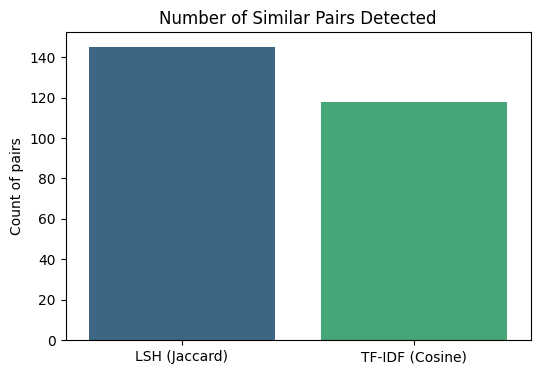

In [14]:
counts = {"LSH (Jaccard)": len(similar_pairs), "TF-IDF (Cosine)": len(cosine_pairs)}

plt.figure(figsize=(6,4))
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="viridis")
plt.title("Number of Similar Pairs Detected")
plt.ylabel("Count of pairs")
plt.show()


In [15]:
G = nx.Graph()
for i,j,_ in similar_pairs + cosine_pairs:
    G.add_edge(i,j)

clusters = [c for c in nx.connected_components(G) if len(c) > 2]
print("Found", len(clusters), "clusters of reviews (size > 2)")

if clusters:
    print("Example cluster (first 5 reviews):")
    example = list(clusters[0])[:5]
    for idx in example:
        print("-", df.loc[idx,'full_text'][:200])


Found 11 clusters of reviews (size > 2)
Example cluster (first 5 reviews):
- The scarlet letter was her passport When people think of a "scarlet letter," we immediate think of a person outwardly branded for something they have done. Credit Nathaniel Hawthorne's "The Scarlet Le
- The scarlet letter was her passport When people think of a "scarlet letter," we immediate think of a person outwardly branded for something they have done. Credit Nathaniel Hawthorne's "The Scarlet Le
- The scarlet letter was her passport When people think of a "scarlet letter," we immediate think of a person outwardly branded for something they have done. Credit Nathaniel Hawthorne's "The Scarlet Le
- The letter was her passport When people think of a "scarlet letter," we immediate think of a person outwardly branded for something they have done. Credit Nathaniel Hawthorne's "The Scarlet Letter" fo


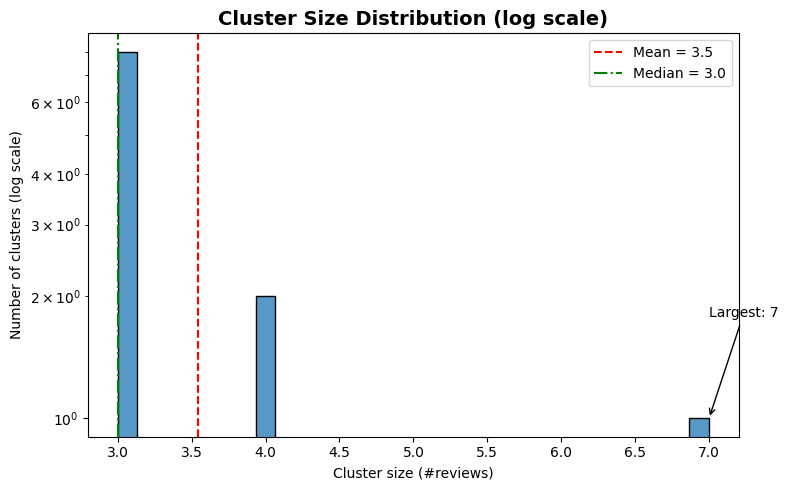

In [16]:
cluster_sizes = [len(c) for c in clusters] if 'clusters' in globals() else []

if not cluster_sizes:
    print("No clusters found (size > 2) — nothing to plot.")
else:
    mean_cs = np.mean(cluster_sizes)
    median_cs = np.median(cluster_sizes)
    largest = np.max(cluster_sizes)

    plt.figure(figsize=(8,5))
    sns.histplot(cluster_sizes, bins=30, edgecolor="black")
    plt.yscale('log')                         # log y-axis for heavy-tailed distributions
    plt.axvline(mean_cs, color='red', linestyle='--', linewidth=1.5, label=f"Mean = {mean_cs:.1f}")
    plt.axvline(median_cs, color='green', linestyle='-.', linewidth=1.5, label=f"Median = {median_cs:.1f}")
    plt.title("Cluster Size Distribution (log scale)", fontsize=14, fontweight="bold")
    plt.xlabel("Cluster size (#reviews)")
    plt.ylabel("Number of clusters (log scale)")
    plt.legend()
    plt.annotate(f"Largest: {largest}", xy=(largest, 1), xytext=(largest, max(1, plt.gca().get_ylim()[1]/5)),
                 arrowprops=dict(arrowstyle="->", color="black"))
    plt.tight_layout()
    plt.show()


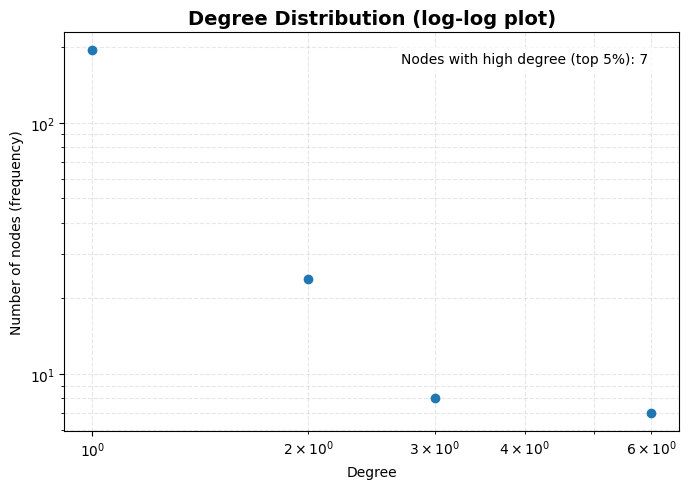

In [17]:

if G.number_of_nodes() == 0:
    print("Graph is empty — no degree distribution to plot.")
else:
    degrees = [d for _, d in G.degree()]
    # degree -> frequency
    deg_series = pd.Series(degrees)
    deg_counts = deg_series.value_counts().sort_index()

    plt.figure(figsize=(7,5))
    # log-log scatter plot for degree vs frequency (common in network analysis)
    plt.loglog(deg_counts.index, deg_counts.values, marker='o', linestyle='none')
    plt.xlabel("Degree")
    plt.ylabel("Number of nodes (frequency)")
    plt.title("Degree Distribution (log-log plot)", fontsize=14, fontweight="bold")

    max_deg = deg_series.max()
    num_hubs = (deg_series >= max(5, int(np.percentile(deg_series, 95)))).sum()
    plt.annotate(f"Max degree: {max_deg}", xy=(max_deg, 1), xytext=(max_deg, max(deg_counts.values)),
                 arrowprops=dict(arrowstyle="->"))
    plt.text(0.95, 0.95, f"Nodes with high degree (top 5%): {num_hubs}", transform=plt.gca().transAxes,
             ha='right', va='top', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    plt.grid(True, which="both", ls="--", alpha=0.3)
    plt.tight_layout()
    plt.show()
